# Final Assessment Scratch Pad

## Instructions

1. Please use only this Jupyter notebook to work on your model, and **do not use any extra files**. If you need to define helper classes or functions, feel free to do so in this notebook.
2. This template is intended to be general, but it may not cover every use case. The sections are given so that it will be easier for us to grade your submission. If your specific use case isn't addressed, **you may add new Markdown or code blocks to this notebook**. However, please **don't delete any existing blocks**.
3. If you don't think a particular section of this template is necessary for your work, **you may skip it**. Be sure to explain clearly why you decided to do so.

## Report

**[TODO]**

Please provide a summary of the ideas and steps that led you to your final model. Someone reading this summary should understand why you chose to approach the problem in a particular way and able to replicate your final model at a high level. Please ensure that your summary is detailed enough to provide an overview of your thought process and approach but also concise enough to be easily understandable. Also, please follow the guidelines given in the `main.ipynb`.

This report should not be longer than **1-2 pages of A4 paper (up to around 1,000 words)**. Marks will be deducted if you do not follow instructions and you include too many words here. 

**[DELETE EVERYTHING FROM THE PREVIOUS TODO TO HERE BEFORE SUBMISSION]**

##### Overview
**[TODO]**

##### 1. Descriptive Analysis
**[TODO]**

##### 2. Detection and Handling of Missing Values
**[TODO]**

##### 3. Detection and Handling of Outliers
**[TODO]**

##### 4. Detection and Handling of Class Imbalance 
**[TODO]**

##### 5. Understanding Relationship Between Variables
**[TODO]**

##### 6. Data Visualization
**[TODO]** 
##### 7. General Preprocessing
**[TODO]**
 
##### 8. Feature Selection 
**[TODO]**

##### 9. Feature Engineering
**[TODO]**

##### 10. Creating Models
**[TODO]**

##### 11. Model Evaluation
**[TODO]**

##### 12. Hyperparameters Search
**[TODO]**

##### Conclusion
**[TODO]**

---

# Workings (Not Graded)

You will do your working below. Note that anything below this section will not be graded, but we might counter-check what you wrote in the report above with your workings to make sure that you actually did what you claimed to have done. 

## Import Packages

Here, we import some packages necessary to run this notebook. In addition, you may import other packages as well. Do note that when submitting your model, you may only use packages that are available in Coursemology (see `main.ipynb`).

In [95]:
import pandas as pd
import os
import numpy as np
from util import show_images, dict_train_test_split
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt


## Load Dataset

The dataset provided is multimodal and contains two components, images and tabular data. The tabular dataset `tabular.csv` contains $N$ entries and $F$ columns, including the target feature. On the other hand, the image dataset `images.npy` is of size $(N, H, W)$, where $N$, $H$, and $W$ correspond to the number of data, image width, and image height, respectively. Each image corresponds to the data in the same index of the tabular dataset. These datasets can be found in the `data/` folder in the given file structure.

A code snippet that loads and displays some of the data is provided below.

### Load Tabular Data

In [96]:
df = pd.read_csv(os.path.join('data', 'tabular.csv'))
print(df.shape)
df.head()

import math

# Object columns
object_columns = df.dtypes[df.dtypes == 'object']
print('Object columns', object_columns.shape[0])

(357699, 61)
Object columns 18


### Load Image Data

Shape: (357699, 8, 8)


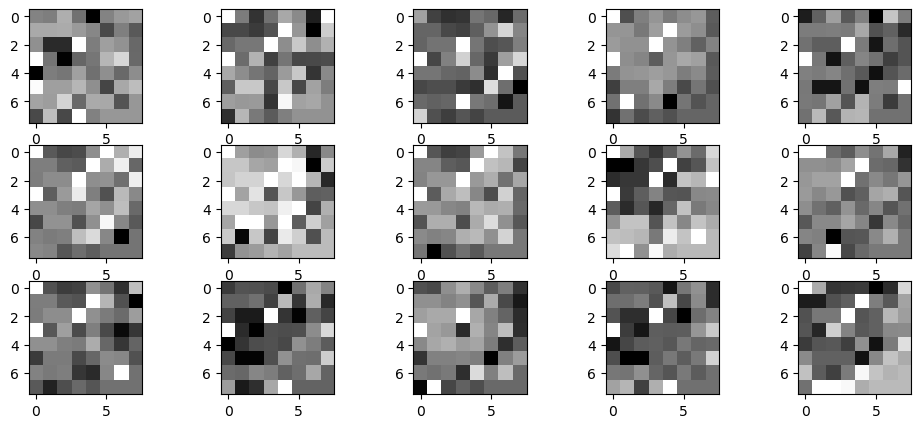

(357699, 64)

In [114]:
with open(os.path.join('data', 'images.npy'), 'rb') as f:
    images = np.load(f)
    
print('Shape:', images.shape)
show_images(images[:18], n_row=3, n_col=5, figsize=[12,5])
images.reshape(images.shape[0], -1).shape

## Data Exploration & Preparation

### 1. Descriptive Analysis

In [121]:
Y = df['target']
X = df.drop('target', axis=1)

def nan_columns(X, threshold=0.5):
    count = X.shape[0] * threshold
    nan_columns = X.isna().sum()
    return nan_columns[nan_columns >= count].index
def zero_columns(X, threshold=0.5):
    count = X.shape[0] * threshold
    zero_cols = (X == 0).sum()
    return zero_cols[zero_cols >= count].index

def object_columns(X):
    return X.dtypes[X.dtypes == 'object'].index

def convert_to_ordinal(X, columns):
    encoder = OrdinalEncoder()
    return encoder.fit_transform(X[columns])

def correlated_columns(X, threshold=0.99):
    corr = X.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    return [column for column in upper.columns if any(upper[column] > threshold)]

# Identify columns with High Nans
nan_columns = nan_columns(X, 0.5)
print('Columns with high NaNs:', nan_columns)
zero_cols = zero_columns(X, 0.9)
print('Columns with high zeros', zero_cols)
object_columns = object_columns(X)
ordinal_columns = convert_to_ordinal(X, object_columns)
X[object_columns] = ordinal_columns

correlated_cols = correlated_columns(X, 0.95)

columns_to_drop = list(set(nan_columns) | set(zero_cols) | set(correlated_cols))
print(columns_to_drop)


Columns with high NaNs: Index(['V15', 'V38', 'V39', '0', '19', '24'], dtype='object')
Columns with high zeros Index(['55', '61', '62', '63'], dtype='object')
['42', '60', '35', 'V20', 'V35', '5', '0', '57', '63', '2', '9', '12', '40', 'V41', '53', '33', '20', '29', '50', '58', 'V40', '28', 'V39', '52', '37', '54', 'V52', '61', '56', '39', '21', 'V45', 'V7', '47', '51', '55', 'V26', '16', '41', 'V15', '19', '62', '14', '25', '49', '22', '7', '4', '18', '36', '13', 'V48', 'V49', '23', '1', '48', 'V44', '6', 'V11', 'V53', '32', 'V38', '43', '11', '44', 'V10', '3', 'V2', '15', '38', '30', '45', '26', '24', 'V43', '34', '46', 'V42']


In [122]:
X_dropped = X.drop(columns_to_drop, axis=1)
X_dropped

V0      V1        V3     V4          V5        V6      V8   V9  \
0        8315.0  1784.0   37115.0  317.0  105.016815  296559.0  2470.0  1.0   
1        8315.0  1272.0   18683.0  230.0         NaN  340059.0  2820.0  0.0   
2        8315.0  3832.0  147707.0  607.0  105.018240  279159.0  2330.0  1.0   
3        8315.0  2296.0   55547.0  404.0         NaN  313959.0  2610.0  1.0   
4       11021.0  1784.0   37115.0  375.0  105.024985  232701.0  1490.0  0.0   
...         ...     ...       ...    ...         ...       ...     ...  ...   
357694   8315.0  1272.0   18683.0  230.0  105.012445  270459.0  2260.0  0.0   
357695   8315.0  2296.0   55547.0  404.0         NaN  244359.0  2050.0  0.0   
357696   8315.0  1784.0   37115.0  375.0         NaN  348759.0  2890.0  0.0   
357697   8315.0  1784.0   37115.0  375.0  105.016815  348759.0  2890.0  0.0   
357698   8315.0  1784.0   37115.0  317.0         NaN  244359.0  2050.0  0.0   

          V12     V13  ...   V56   V57  V58          V59         8        10  \
0        85.0   737.0  ...  1089   293  2.0  7428.249334  0.249110  0.283362   
1        42.0   585.0  ...  9801  1085  7.0  9693.829502 -1.144696 -1.343454   
2       335.0  1041.0  ...  1485   304  6.0  7609.258214  0.129641 -0.258910   
3       113.0   889.0  ...  -495   711  4.0  4258.532609  0.726987  0.283362   
4       186.0   737.0  ...  1683   117  0.0  9492.484802  0.249110  0.283362   
...       ...     ...  ...   ...   ...  ...          ...       ...       ...   
357694    4.0   585.0  ...  6336  1855  2.0  4634.276235 -4.290717 -2.427998   
357695  110.0   889.0  ...  2970   854  8.0  8379.073980  0.129641 -0.258910   
357696  163.0   737.0  ... -4257   942  8.0  5359.986193  0.408403  0.283362   
357697  147.0   737.0  ...  2376  1195  7.0  9095.239127  0.726987  0.283362   
357698   46.0   737.0  ...  9108   502  3.0  9379.720939  0.129641 -0.258910   

              17        27        31        59  
0      -1.523953 -0.689523 -0.637881  1.465378  
1      -0.425715 -1.246596 -1.090949 -0.852887  
2       0.306444  1.538767  1.627457 -0.080132  
3       0.672524 -0.132450 -0.184813 -0.080132  
4      -0.425715 -0.410987 -0.637881  1.465378  
...          ...       ...       ...       ...  
357694 -4.086510 -1.246596 -1.090949  2.238133  
357695  0.306444 -0.132450 -0.184813 -0.080132  
357696  0.672524 -0.410987 -0.637881 -0.080132  
357697  0.672524 -0.410987 -0.637881 -0.080132  
357698  0.306444 -0.689523 -0.637881 -0.080132  

[357699 rows x 46 columns]

In [134]:
print(X_dropped.shape)

(357699, 46)


### 2. Detection and Handling of Missing Values

In [135]:
# For the columns with nan's that are not the object columns, fill them with mean
# For the object columns, fill them with the mode
X_missing = X_dropped.fillna(X_dropped.mean())
# TODO: Replace with mode for object columns

### 3. Detection and Handling of Outliers

In [151]:
# Time to do PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_missing)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y)
# plt.colorbar()
# plt.show()

In [155]:
res = 0
variance = pca.explained_variance_ratio_
for i in range(len(variance)):
    if np.sum(variance[0:i]) >= 0.99:
        res = i
        break
print(np.sum(variance[:res]))
print(res)


0.9999008890228839
2


### 4. Detection and Handling of Class Imbalance

### 5. Understanding Relationship Between Variables

### 6. Data Visualization

## Data Preprocessing

### 7. General Preprocessing

### 8. Feature Selection

### 9. Feature Engineering

## Modeling & Evaluation

### 10. Creating models

In [158]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X_missing, Y, test_size=0.2, random_state=42)

In [159]:
# Linear Regression
# # Train the model
model = LinearRegression()
model.fit(X_train, y_train)
# # Predict
y_pred = model.predict(X_test)
# # Evaluate
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)


MSE: 5311.417393315556


### 11. Model Evaluation

### 12. Hyperparameters Search